# Lab 8- ML Classification with ScikitLearn

Based on Chapter 3 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)


## Summary
In the previous lecture we did regression and classification of geophysical data, putting emphasis on the whole dataflow.\
For the next few lectures, we will focus on individual steps and algorithms with pre-prepared data.\
In this notebook we will look at the problem of classification, that is to assign a label to each input.\
Classification is different from regression because the target is a discrete value.\
In this practice we will use the MNIST data set to look at binary and multiclass classification problems:
* Binary: 
Each class is just one between two classes.
* MultiClass: 
Each input will be assigned a label among several classes


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice8-Classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## MNIST
MNIST is a dataset commonly used for teaching machine learning.
It is the "hello world" version of programming. 
See [MNIST](https://en.wikipedia.org/wiki/MNIST_database)

In [2]:
from tensorflow import keras
import tensorflow as tf
useSL=False
if useSL:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    print(type(mnist))
    mnist.keys()
else: #use TF 
    mnist = keras.datasets.mnist


If using Scikit-Learn the data set is a ```Bunch```, which is a Python dictionary that provides attribute-style access (like in JavaScript objects). \
**Bunchs** act like an object and a dictionary. In this case, the dictionary contains panda objects (and their keys)

In [7]:
if useSL:
    X, y = mnist["data"], mnist["target"]
    print(type(X),X.shape,type(y),y.shape)
else:
    (X,y),(Xt,yt) = mnist.load_data()
    X=X[:60000].reshape(60000,28*28) # to make it compatible with SL version
    y=y[:60000]

    print(type(X),X.shape,type(y),y.shape)

<class 'numpy.ndarray'> (60000, 784) <class 'numpy.ndarray'> (60000,)


In [8]:
try:
    X=X.to_numpy(copy=True)
except:
    print("already numpy array")

already numpy array


We can form square matrices from the 1D samples to treat them as images

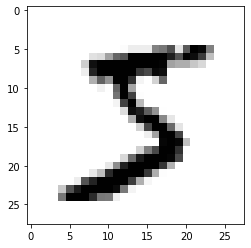

In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary);

In SL the type is string, but algorithms do now usually work with strings, so we need to convert to a number.

In [15]:
if y.dtype != 'uint8':
    y=y.astype(np.uint8)
else:
    print('y is ', y.dtype)


y is  uint8


We will be making many plots, so better simplify it with functions

In [16]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,interpolation="nearest")
    plt.axis("off")

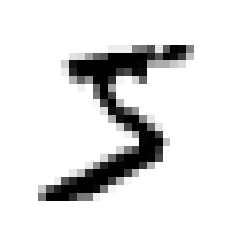

In [17]:
plot_digit(X[0])

In [18]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

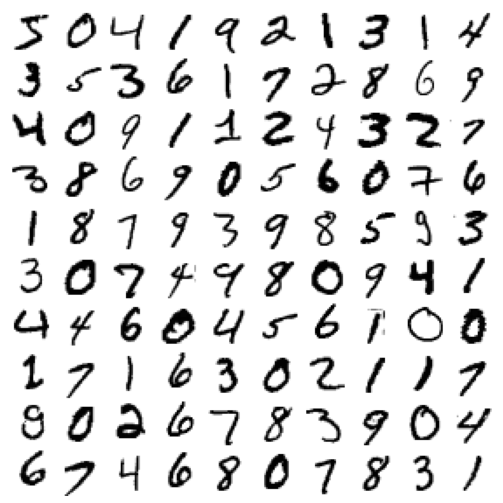

In [13]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

Let us divide the data in training and testing

In [19]:
if useSL:
    X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
else:
    X_train = X.reshape(60000,28*28)
    X_test = Xt.reshape(10000,28*28)
    y_train = y
    y_test = yt

## Binary Classifier
Although the final task will be to classify the data into 10 different classes (digits 0 to 9),\
we will first learn how to do binary classification (true-false), but choosing only one class and predicting whether digits belong to it.\
Let us choose number 5 (just because it happens to be the first sample) but feel free to chose a different number.\
By using a boolean condition we move from multi-class to binary. 

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [21]:
y_train_5[:4]

array([ True, False, False, False])

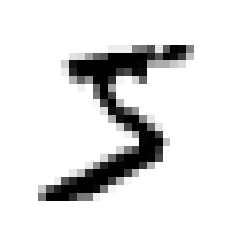

In [22]:
plot_digit(X_train[0])

We will illustrate some common classification methods in Scikit-learn, without looking at the algorithms in detail (yet).\
In further lectures we will study these algorithms, but for now we want to focus on the classification problem as a general task.\
One first algorithm to try is Stochastic Gradient Descent, which is a general steepest descent method (follows the negative of the gradient of the cost function) calculated on batches (small groups of samples).


In [23]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, n_jobs=10)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(n_jobs=10, random_state=42)

In [24]:

some_digit=X_train[1]
sgd_clf.predict([some_digit])

array([False])

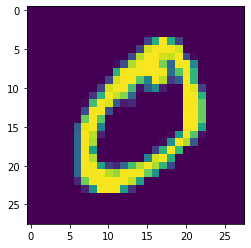

In [25]:
plt.imshow(some_digit.reshape((28,28)))

We can use the crossvalidation function from sklearn (see lecture 6)

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

In this case, we used the cross_val_score function implemented in sklearn.\
To demistify what the function does, take a look at the function below that is equivalent.\
We need to use other functions to separate the testing portion on each fold and create copies of the classifier.

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


The scores are quite high but we need to notice that we are doing ***imbalanced*** classification.\
There are only 10% of '5's in the dataset. So even by always answering the samples are not '5' 
we are right 90% of the time.\
Check the excellent material from Jason Brownlee in the link [imbalanced classification](https://machinelearningmastery.com/imbalanced-classification-is-hard/)

Let us prove this by creating a class that always returns zeroes. We need a class to use the cross_val_score function.\
A requirement of the this function is that the class needs to be inherent from the BaseEstimator and declare "fit" and "predict" methods.


In [28]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Clearly we are doing a horrible job (all predictions are negative) but the accuracy is still high.\
To work with imbalanced data sets we need to use different metrics than accuracy (percentage of times we get the right answer).\
There are many types of scores that serve better for these cases. \
Let us start by predicting the results for the training data set and use the predicted vs original labels to qualify results.\
We can use a cross_validation rapper for predicting (rather than scoring as before).


In [30]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [31]:
print(type(y_train_pred),y_train_pred.shape,' - One sample ->',y_train_pred[0])

<class 'numpy.ndarray'> (60000,)  - One sample -> True


One of the most common approches is the confusion matrix.\
The number of times we get the right results appear along the diagonal. Off-diagonal represent the number of times
we got results wrong. \
The labels (Negative, Positive) appear as rows for the input (True) or columns for the predictions.

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The perfect result would be when the predictions are equal to the labels.\
In that case, the confusion matrix becomes diagonal.

In [33]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The following figure from Geron's book illustrates the concept much better:\
![Confussion Matrix](confussionMatrix.png)

As seen in the Figure, the matrix also has too axes, precision and recall.\
The precision score is defined as:

$$precision=\frac{TP}{TP+FP}$$

The recall score is:

$$recall=\frac{TP}{TP+FN}$$

Precision implies the ratio of correct possitives (diagonal term) divided by the sum of the corresponding column (true and false positives). \
It represents how well we do when the goal is to make sure we don't have false positives going through.

Recall implies the ratio of correct positives (diagonal term) divided by the sum of the corresponding row.\
It represents how well we do when the goal is to make sure we don't have false negatives going through. 


In [34]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [35]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

There are other scores. The F1 score is the harmonic mean of precision and score:
$$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}= \frac{TP}{TP+\frac{FN+FP}{2}}$$



In [36]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

There is a trade-off between precision and recall. To understand it, we can look at the decision function.\
One way to do classification is to predict a value (like regression) and then check whether the value predicted is above or below a threshold. \
This is called the decision function. For example, let us return the decision function value from the classifier instead of the decision itself:

array([2164.22030239])

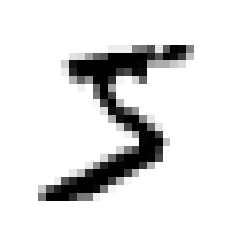

In [39]:
some_digit=X_train[0]
plot_digit(some_digit)
y_scores = sgd_clf.decision_function([some_digit])
y_scores

By default, the threshold is set to 0. But you can change that (also you can change the decision function).

In [40]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


Changing the threshold changes the classification result.

In [41]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Clearly, it is not trivial to come up with the right threshold for each case.\
We can decide a threshold by looking at how the precision and recall behave.\
First we need to see the scores, for which we can use the cross_val_scores function\
With the method "decision_function" there will be scores for different thresholds.

In [42]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function",n_jobs=10)

The returned y_scores allow us to get a continuous variation of precision and recall with threshold

In [43]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(59966,)
(59967,)
(59967,)


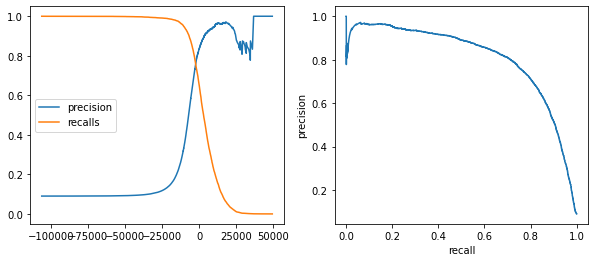

In [44]:
print(type(precisions),type(recalls),type(thresholds))
print(thresholds.shape)
print(precisions.shape)
print(recalls.shape)

fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(thresholds,precisions[:-1],label='precision')
ax[0].plot(thresholds,recalls[:-1],label='recalls')
ax[0].legend()

ax[1].set_xlabel('recall')
ax[1].set_ylabel('precision'),
ax[1].plot(recalls[:-1],precisions[:-1]);


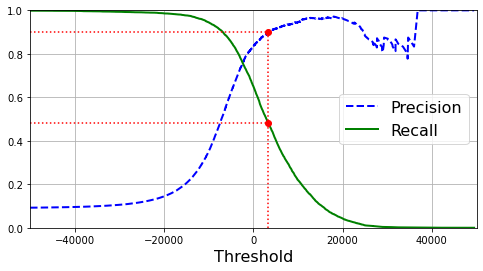

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

## Receiver Operating Characteristic (ROC)
Plots True Positive Rate (TPR) which is the same as recall vs False Positive Rate (FPR) \
which is the ratio of false instances incorrectly classified as possitive.\
The ROC curve is more appropriate for balanced classification, \
The Precision/Recall curve is more appropriate for imbalanced classification.\
The larger the area under the curve, the better the classifier (for both)


In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
print(fpr.shape,tpr.shape,thresholds.shape)

(3908,) (3908,) (3908,)


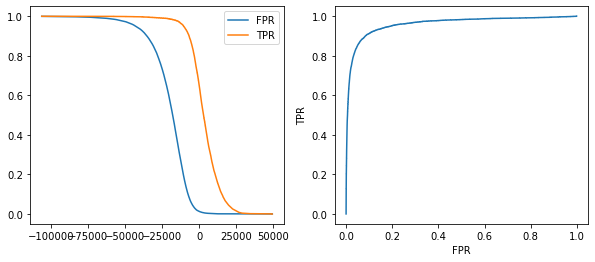

In [47]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(thresholds[:-1],fpr[:-1],label='FPR')
ax[0].plot(thresholds[:-1],tpr[:-1],label='TPR')
ax[0].legend()

ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR'),
ax[1].plot(fpr[:-1],tpr[:-1])

## Example: compare the ROC for SGD vs Forest Regression.
Let us create the binary classifier for the number '5' using:
* Stochastic Gradient Descent (already done) 
* RandomForestClassifier.

Then we can compare both. The curve with the largest area is the best (in this case Random Forest)


In [48]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train_5, y_scores)

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba",n_jobs=10)
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

We take the second column of the probabilities because is the prob of a positive answer.

In [50]:
y_probas_forest[0]

array([0.11, 0.89])

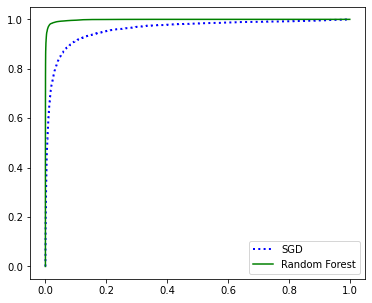

In [51]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest,"g-",label="Random Forest")
plt.legend();

Acording to this tests, Random Forest is doing a more accurate predictions, since the area is larger.

## Multiclass 
So far we have been doing binary classification (is it 5? True,False).\
Classifying digits actually is a multiclass problem (is it 0,1,2..?\
There are two ways to do this:
1. training 10 classifiers and getting a score for each (like we did for the number 5).\
This is called One vs Rest (OVR). It is a small number of large problems (10 large problems).
2. training many classifiers that compare each number against each number (0 with 1, 0 with 2..., 1 with 2, 1 with 3, ... and so on). \
This is called One Vs One (OVO). For N classes, the number of binary classifiers we need is $N \times (N-1) / 2$\
For 10 digits will need $10*9/2=45$. That is, many small problems instead of fewer larger problems.

Some classifiers work better with small problems, some do better with few large problems.\
sklearn takes a default decision for each method but you can change the default.\
Let us see now the SGDClassifier for all the 10 digits (instead of just 5). \
Using sklearn, the only difference is that now labels have different values instead of booleans.\
This will take 10 times longer to run than the initial problem of classifying '5' because we are doing this 10 times.

In [52]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train)

SGDClassifier(n_jobs=-1, random_state=42)

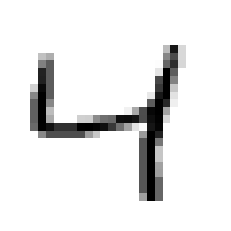

In [53]:
some_digit = X[2]
plot_digit(some_digit)

In [54]:
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

Now, an important question is what was the criteria the classifier used to decide on 8 instead of for example 2?\
Just like before when we discussed the threshold, we can look at the decision function.

In [55]:
sgd_clf.decision_function([some_digit])

array([[-34143.40703505, -21942.13780869,  -4018.29275037,
         -2239.19313075,     43.09419826, -15058.88052383,
        -33653.31059893,  -8277.80610963,  -7460.52016321,
        -14180.15338984]])

In [56]:
np.argmax(sgd_clf.decision_function([some_digit]))

4

We can look at the scores as before using the cross-validation function to see how well this is working for different
cases. 

In [59]:
y_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3,scoring="accuracy",n_jobs=-1)

In [60]:
print(y_scores)

[0.87365 0.85835 0.8689 ]


To improve the scores, we can use a standard scaler. This helps the algorithm by making the model space more uniform.

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_scores_scale=cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy",n_jobs=-1)

In [62]:
print(y_scores_scale)

[0.8983 0.891  0.9018]


Now we want to look at the confussion matrix for all the digits!

In [63]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3,n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

<class 'numpy.ndarray'>


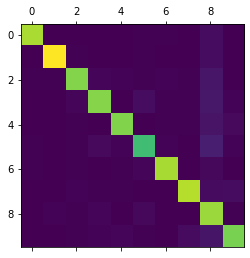

In [64]:
print(type(conf_mx))
plt.matshow(conf_mx)

To see how it is doing for each digit, we can plot the matrix scaled by the total number of cases on each row (total cases per class).\
Also, we can remove the diagonal (the number of cases classified right) to see just the wrong classification cases.

[1. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


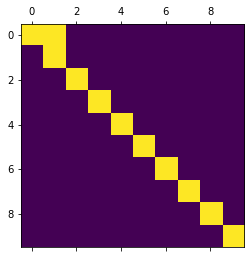

In [69]:
# testing np.sum
test=np.eye(10)
test[0,1]=1
plt.matshow(test)
print(test.sum(axis=0))
print(test.sum(axis=1))

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

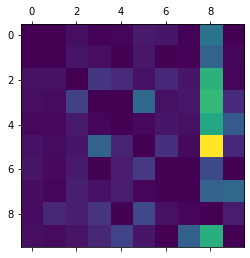

In [71]:
plt.matshow(norm_conf_mx)

This tells us that many numbers have been classified as '8's, without being '8's.\
However, not many '8's have not been classified as 8s.


## Multilabel classification
In some cases we may need to classify in non-mutually excluding classes. \
For example, we might want to classify cases where the digit is both large and an even number. \
In that case, we need an output that can be True for different criteria at the same time.\
Below there is an example where there are two different labels (large and odd).\
This example uses a different classifier, KNeightborsClassifier, which we will see in a later lecture (not all classifiers allow this) \
The example illustrates how multilabel is different than single label but from our point of view we just need to specify to the classifier a multitarget. \
Clever programmers in scikit learn made the class to recognize multilabel targets and call a different algorithm.

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [75]:
y_multilabel.shape

(60000, 2)

array([[False,  True]])

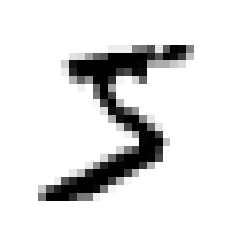

In [82]:
some_digit=X_train[0]
plot_digit(some_digit)
knn_clf.predict([some_digit])

The digit (5) is not larger than 7 (False to the first criteria), and odd (True to the second criteria).\
The result was correct for the two targets. \
Let us use cross-validation again to run several predictions (3 different folds) and evaluate how it performs.

In [83]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=10)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multilabel-Multiclass classification (multioutput)

What happens if we can have multilabels and multiclasses? \
Let us see an example of a digit contaminated with noise. 
If we think in terms of pixels rather than images, the problem is:
* multilabel (one label per pixel, 28x28)
* multiclass (each pixel can have different intensity (0-255)



In [84]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Different from before, the labels are now the original pixels (much larger targets than just one number between 0 and 9)

In [85]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

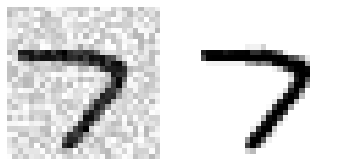

In [86]:
some_index = 70
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Without really looking under the hood, we see that a classifier can predict each pixel intensity.\
Because the labels were clean, the method is predicting clean pixels.

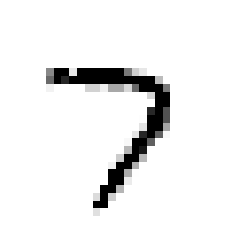

In [87]:

clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)